#  Taxi Demand Prediction

**Project Description**

The company "Чётенькое такси" has collected historical data on taxi orders at airports. To attract more drivers during peak hours, it is necessary to forecast the number of taxi orders for the next hour. Build a model for such prediction.

The value of the RMSE metric on the test dataset should not exceed 48.

You need to:

1. Load the data and resample it by one hour.
2. Analyze the data.
3. Train different models with various hyperparameters. Create a test dataset consisting of 10% of the original data.
4. Validate the data on the test dataset and draw conclusions.

**Work plan:**

To solve the prediction task we will:

1. Perform initial data analysis.
2. Prepare the data for machine learning.
3. Apply regression machine learning methods.
4. Validate the best model on the test dataset.
5. Compare the results obtained and summarize the research.

## Data Preprocessing

In [1]:
pip install prophet --quiet

In [2]:
pip install pmdarima --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import xgboost as xgb
from prophet import Prophet
from pmdarima import auto_arima
from sklearn.dummy import DummyRegressor
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit

In [4]:
try:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    url = "https://code.s3.yandex.net/datasets/taxi.csv"
    df = pd.read_csv(url, index_col=[0], parse_dates=[0])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
df.sample(10)

,num_orders
datetime,
2018-05-03 16:50:00,12
2018-08-12 00:10:00,17
2018-03-12 15:30:00,23
2018-07-14 19:40:00,11
2018-08-09 14:20:00,9
2018-05-29 00:10:00,10
2018-04-30 07:20:00,3
2018-04-05 07:30:00,3
2018-06-07 20:20:00,16


In [7]:
# checking for missing values
df.isna().mean()

num_orders    0.0
dtype: float64

In [8]:
# let's take a look at the demand distribution
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


<Axes: title={'center': 'Distribution in "num_orders" column'}, ylabel='Number of orders'>

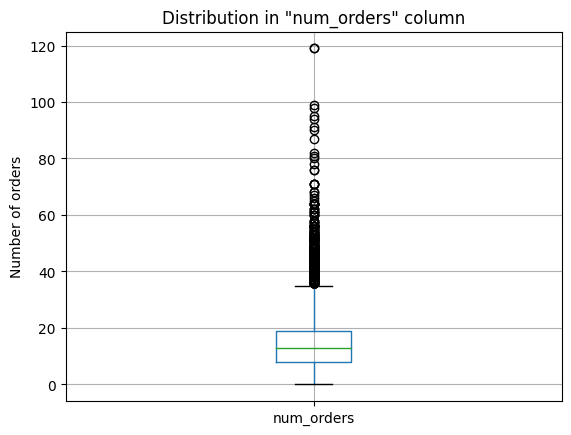

In [9]:
plt.title('Distribution in "num_orders" column')
plt.ylabel('Number of orders')
df.boxplot(['num_orders'])

In [10]:
# checking the earliest date in the dataframe
df.index.min()

Timestamp('2018-03-01 00:00:00')

In [11]:
# checking the most recent date in the dataframe
df.index.max()

Timestamp('2018-08-31 23:50:00')

In [12]:
# making sure that the dates are sorted
df.index.is_monotonic_increasing

True

In [13]:
# resampling dates by 1 hour
df = df.resample('1H').sum()

In [14]:
# checking the results or resampling
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


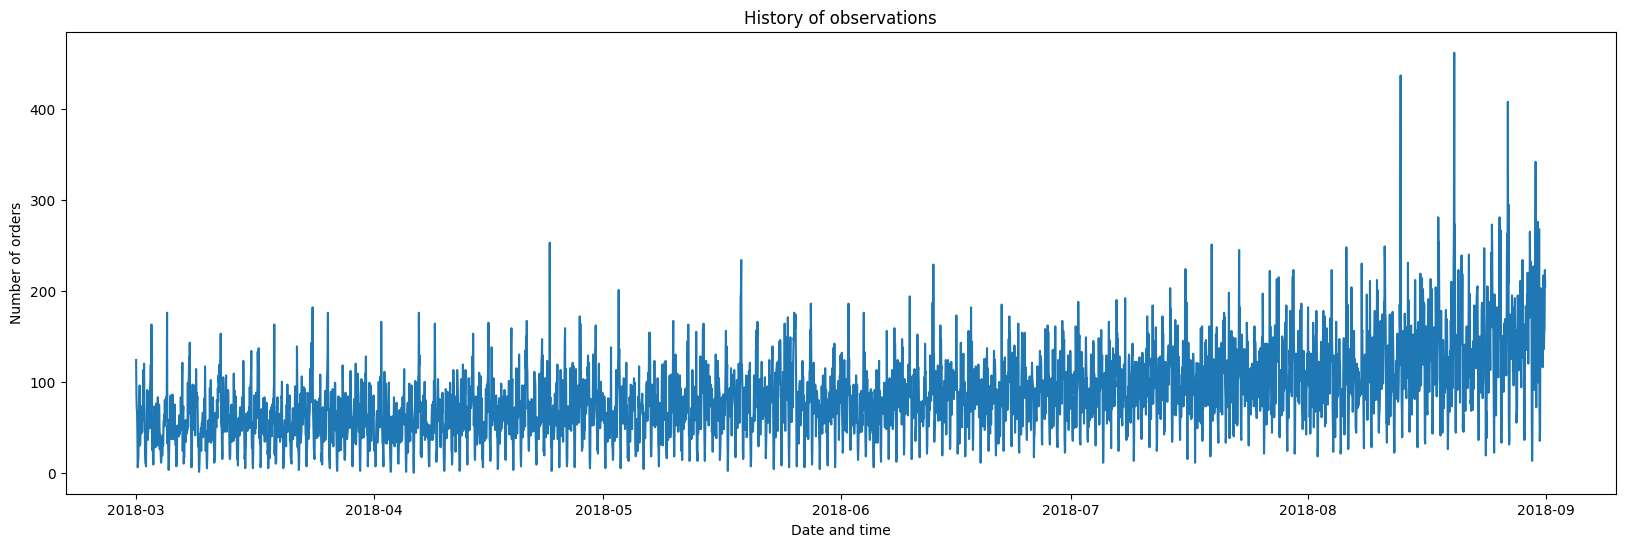

In [15]:
# let's plot a graph for the entire observation period
plt.figure(figsize=(20, 6))
plt.plot(df)
plt.xlabel('Date and time')
plt.ylabel('Number of orders')
plt.title('History of observations')
plt.show()

The data is presented for the period from March to August 2018. No additional processing is required as we have already resampled the data to one hour. It can be observed that the number of orders increases towards the end of the observation period. Additionally, there are distinct peaks in April, May, and June.

## EDA

In [16]:
# let's write a function to add new features to the dataframe
# we will add lag features for 1 hour, 1 day, and 1 week
# we will also add rolling averages for 1 week and 1 day

def make_features(df):
    data = df.copy()
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek

    data['lag_1_hour'] = data['num_orders'].shift(1)
    data['lag_1_day'] = data['num_orders'].shift(24)
    data['lag_1_week'] = data['num_orders'].shift(168)

    data['rolling_mean_week'] = data['num_orders'].shift().rolling(168).mean()
    data['rolling_mean_day'] = data['num_orders'].shift().rolling(24).mean()

    data.dropna(inplace = True)

    return data

In [17]:
df_new = make_features(df)
print(df_new.head())

                     num_orders  day  dayofweek  lag_1_hour  lag_1_day  \
datetime                                                                 
2018-03-08 00:00:00         143    8          3        94.0      100.0   
2018-03-08 01:00:00          78    8          3       143.0      121.0   
2018-03-08 02:00:00          65    8          3        78.0       24.0   
2018-03-08 03:00:00          68    8          3        65.0       66.0   
2018-03-08 04:00:00          60    8          3        68.0       73.0   

                     lag_1_week  rolling_mean_week  rolling_mean_day  
datetime                                                              
2018-03-08 00:00:00       124.0          54.226190         60.041667  
2018-03-08 01:00:00        85.0          54.339286         61.833333  
2018-03-08 02:00:00        71.0          54.297619         60.041667  
2018-03-08 03:00:00        66.0          54.261905         61.750000  
2018-03-08 04:00:00        43.0          54.273810     

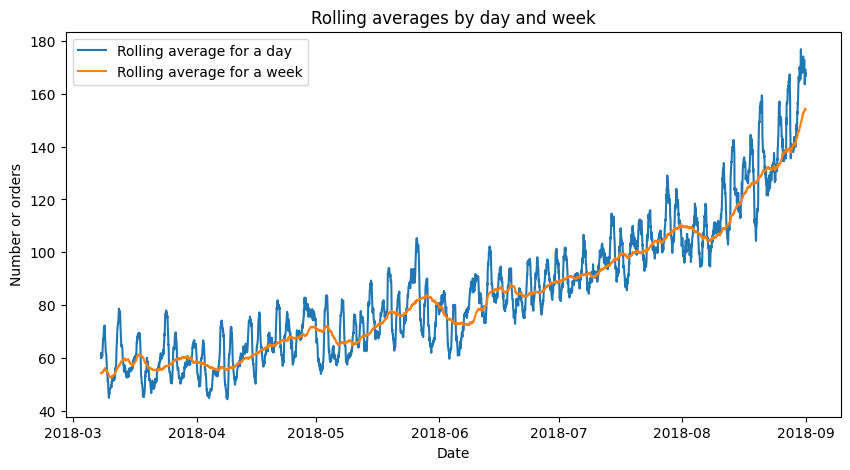

In [18]:
# let's plot the rolling averages for the entire observation period
plt.figure(figsize=(10,5))
plt.xlabel('Date')
plt.ylabel('Number or orders')
plt.title('Rolling averages by day and week')
plt.plot(df_new[['rolling_mean_day', 'rolling_mean_week']])
plt.legend(labels=['Rolling average for a day', 'Rolling average for a week'])
plt.show()

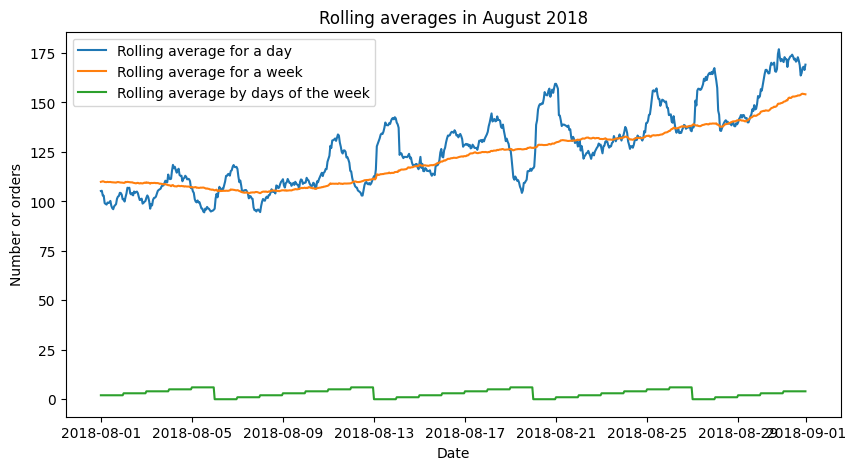

In [19]:
# let's plot the rolling averages for the most recent month
plt.figure(figsize=(10,5))
plt.xlabel('Date')
plt.ylabel('Number or orders')
plt.title('Rolling averages in August 2018')
plt.plot(df_new['2018-08-01':'2018-08-31'][['rolling_mean_day', 'rolling_mean_week', 'dayofweek']])
plt.legend(labels=['Rolling average for a day', 'Rolling average for a week', 'Rolling average by days of the week'])
plt.show()

In [20]:
# data decomposition
decomposed = seasonal_decompose(df)

In [21]:
df_by_day = df.resample('1D').sum()
decomposed_by_day = seasonal_decompose(df_by_day)

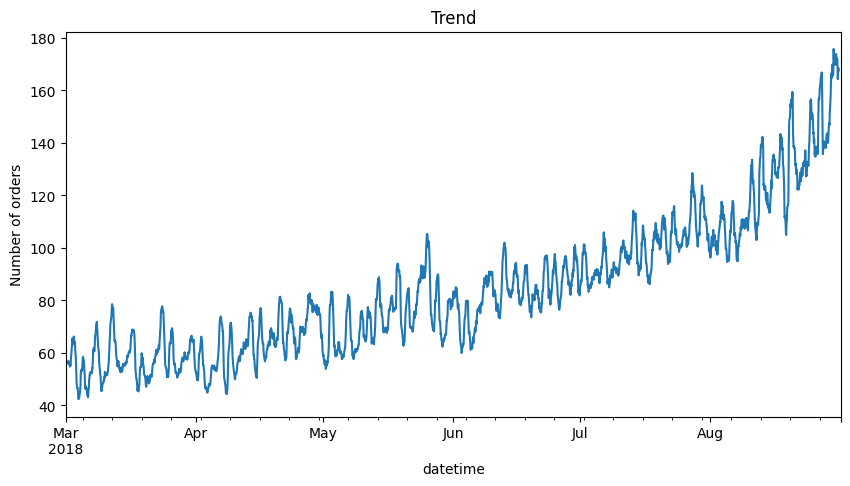

In [22]:
# let's take a look at the overall trend
plt.figure(figsize=(10, 5))
plt.xlabel('Date')
plt.ylabel('Number of orders')
plt.title('Trend')
decomposed.trend.plot(ax=plt.gca());

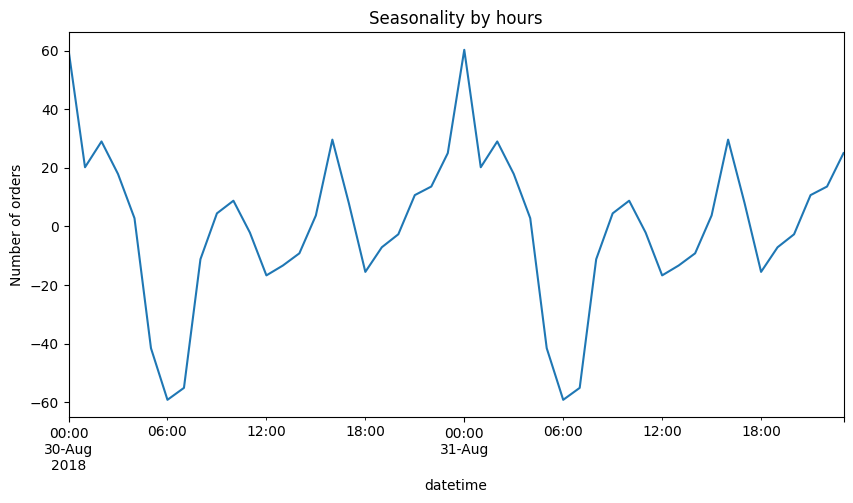

In [23]:
# let's look at the seasonality by hours in the last two days of August 2018
plt.figure(figsize=(10, 5))
plt.xlabel('Date')
plt.ylabel('Number of orders')
plt.title('Seasonality by hours')
decomposed.seasonal['2018-08-30':'2018-08-31'].plot(ax=plt.gca());

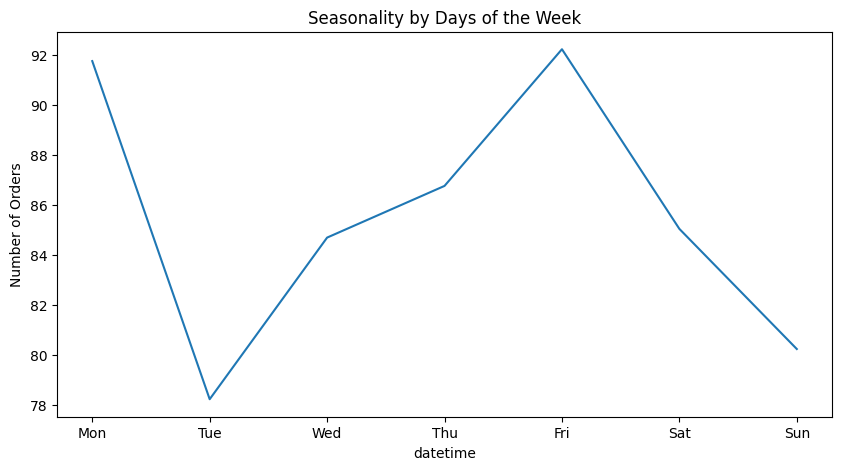

In [24]:
# let's look at the seasonality by days of the week
weekday_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
plt.figure(figsize=(10, 5))
plt.xlabel('Day of the Week')
plt.ylabel('Number of Orders')
plt.title('Seasonality by Days of the Week')
plt.xticks(range(7), weekday_labels)
df_new.groupby(df_new.index.weekday).num_orders.mean().plot();

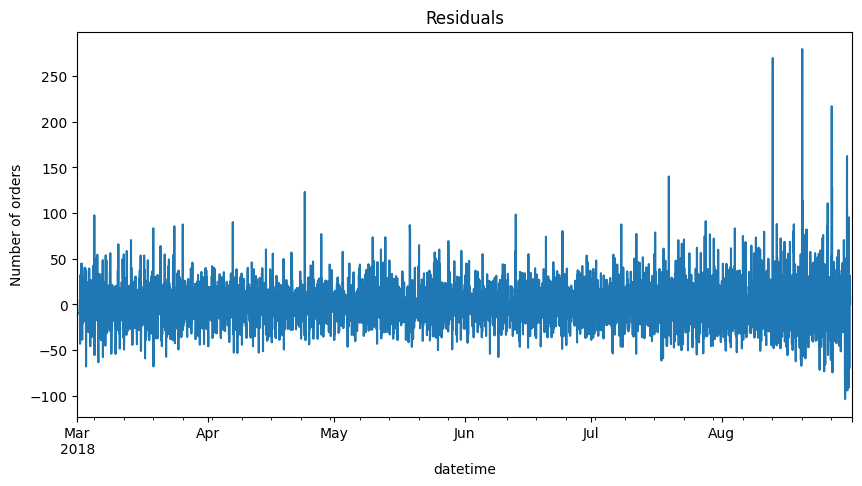

In [25]:
#график остатков
plt.figure(figsize=(10, 5))
plt.xlabel('Date')
plt.ylabel('Number of orders')
plt.title('Residuals')
decomposed.resid.plot(ax=plt.gca());

The following patterns can be observed:
- The number of orders steadily increases over time.
- There are more orders on Mondays and Fridays, and fewer on Tuesdays and Sundays.
- The highest number of orders occurs at midnight and around 5 in the evening, and the lowest number occurs at 6 in the morning.

Thus, the data exhibits daily and weekly seasonality, which can be explained by the flight schedule, which likely remained unchanged throughout the spring-summer period. The peaks in May and during the summer months may be associated with May holidays and the vacation season. From the residuals plot, it can be seen that the last weeks of August deviate from the overall pattern, indicating less stationarity in the data, which could potentially lower the prediction quality.

In [26]:
# let's perform the Dickey-Fuller test to check the stationarity of the time series with a significance level of 5%

result = adfuller(df['num_orders'], autolag='AIC')

print('ADF Statistic: %f' % result[0])
print('P-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print("Null hypothesis rejected - Time series is stationary")
else:
    print("Null hypothesis not rejected - Time series is not stationary")

if result[0] < result[4]["1%"]:
    print("Null hypothesis rejected - Time series is stationary")
else:
    print("Null hypothesis not rejected - Time series is not stationary")

ADF Statistic: -3.068924
P-value: 0.028940
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Null hypothesis rejected - Time series is stationary
Null hypothesis not rejected - Time series is not stationary


At a significance level of 5%, the time series is stationary. However, at a significance level of 1%, the time series cannot be considered as stationary.

## Model Training

In [27]:
# splitting data into training and testing samples

train, test = train_test_split(df_new, test_size=0.1, shuffle=False)

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

# deleting missing values
train = train.dropna()

2018-03-08 00:00:00 2018-08-14 06:00:00
2018-08-14 07:00:00 2018-08-31 23:00:00


In [28]:
# defining the target value

target_train = train['num_orders']
features_train = train.drop('num_orders', axis=1)

target_test = test['num_orders']
features_test = test.drop('num_orders', axis=1)

In [29]:
tscv = TimeSeriesSplit(n_splits=3)

### LinearRegression

In [30]:
# LinearRegression

param_grid = {}

# initialization

model = LinearRegression()

# params for RandomizedSearchCV

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                                   n_iter=10, scoring='neg_root_mean_squared_error', cv=tscv, random_state=42)
random_search.fit(features_train, target_train)


best_params_lr = random_search.best_params_
best_model_lr = random_search.best_estimator_

rmse_lr = random_search.best_score_*(-1)

print("RMSE on testing sample:", rmse_lr)

RMSE on testing sample: 24.06518572766117


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


### LGBM

In [31]:
%%time

# LGBM

# initialization
model_lgbm = LGBMRegressor(random_state=42)

# params for RandomizedSearchCV
params_lgbm = {'n_estimators': [270, 300, 320],
                'num_leaves':[13, 14, 15],
                'learning_rate':[0.01, 0.1],
                'max_depth': [11, 12, 15]}



grid_lgbm = RandomizedSearchCV(model_lgbm, param_distributions = params_lgbm, scoring='neg_root_mean_squared_error',
                               cv=tscv, random_state=42)

grid_lgbm.fit(features_train, target_train)
rmse_lgbm = grid_lgbm.best_score_*(-1)
print("Best RMSE:", rmse_lgbm)
print("Best params:", grid_lgbm.best_params_)

Best RMSE: 24.489536220925444
Best params: {'num_leaves': 13, 'n_estimators': 300, 'max_depth': 12, 'learning_rate': 0.01}
CPU times: user 22.5 s, sys: 333 ms, total: 22.9 s
Wall time: 24.5 s


### XGBoost

In [32]:
%%time

# XGBoost

# initialization
xgb_model = xgb.XGBRegressor(random_state=42)

# params for RandomizedSearchCV
param_grid = {
    'max_depth': [1, 2, 3, 5],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [500, 550, 600]
}

random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_grid,
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=tscv,
    verbose=1,
    random_state=42
)

random_search.fit(features_train, target_train)

best_model = random_search.best_estimator_

rmse_xgb = np.sqrt(-random_search.best_score_)
print("Best RMSE:", rmse_xgb)
print("Best params:", random_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best RMSE: 24.43709426205192
Best params: {'n_estimators': 600, 'max_depth': 2, 'learning_rate': 0.01}
CPU times: user 44.3 s, sys: 430 ms, total: 44.7 s
Wall time: 34 s


### LSTM

In [33]:
%%time

# LSTM

# scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# splitting into training and testing samples
train_size = int(len(scaled_data) * 0.9)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# creating sequences for LSTM
def create_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# setting a sequence length
sequence_length = 25

X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

X_train = np.reshape(X_train, (X_train.shape[0], sequence_length, 1))
X_test = np.reshape(X_test, (X_test.shape[0], sequence_length, 1))

# setting params
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# model training
model.fit(X_train, y_train, epochs=10, batch_size=16)

predictions = model.predict(X_test)

predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)

# RMSE
rmse_lstm = np.sqrt(mean_squared_error(y_test, predictions))
print("RMSE:", rmse_lstm)


Epoch 1/10
247/247 [==============================] - 6s 15ms/step - loss: 0.0065
Epoch 2/10
247/247 [==============================] - 4s 16ms/step - loss: 0.0051
Epoch 3/10
247/247 [==============================] - 3s 13ms/step - loss: 0.0042
Epoch 4/10
247/247 [==============================] - 3s 13ms/step - loss: 0.0039
Epoch 5/10
247/247 [==============================] - 4s 17ms/step - loss: 0.0037
Epoch 6/10
247/247 [==============================] - 3s 13ms/step - loss: 0.0035
Epoch 7/10
247/247 [==============================] - 3s 13ms/step - loss: 0.0033
Epoch 8/10
247/247 [==============================] - 3s 13ms/step - loss: 0.0032
Epoch 9/10
247/247 [==============================] - 4s 17ms/step - loss: 0.0033
Epoch 10/10
14/14 [==============================] - 0s 5ms/step
RMSE: 46.62855879884843
CPU times: user 48.8 s, sys: 1.35 s, total: 50.2 s
Wall time: 43.9 s


### Prophet

In [34]:
%%time

# Prophet

# preparing data
pr_data = pd.read_csv("https://code.s3.yandex.net/datasets/taxi.csv")
pr_data = pr_data.rename(columns={"datetime": "ds", "num_orders": "y"})

# initializing
model = Prophet(yearly_seasonality=True)
model.fit(pr_data)

future = model.make_future_dataframe(periods=len(target_test))
forecast = model.predict(future)
predictions = forecast[-len(target_test):]['yhat'].values

# RMSE
rmse_pr = np.sqrt(mean_squared_error(target_test, predictions))
print("RMSE:", rmse_pr)


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv_mcohz9/ec7ckai0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv_mcohz9/kl3vh42k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11699', 'data', 'file=/tmp/tmpv_mcohz9/ec7ckai0.json', 'init=/tmp/tmpv_mcohz9/kl3vh42k.json', 'output', 'file=/tmp/tmpv_mcohz9/prophet_modeld1s99yas/prophet_model-20230728202135.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:21:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:21:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


RMSE: 75.47424378224046
CPU times: user 10.3 s, sys: 2.25 s, total: 12.6 s
Wall time: 17.5 s


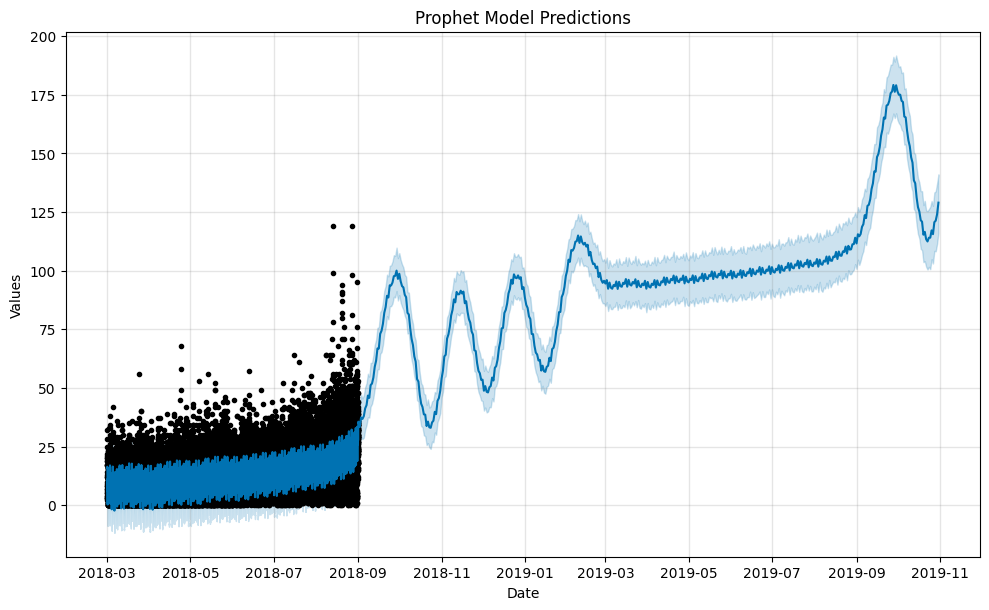

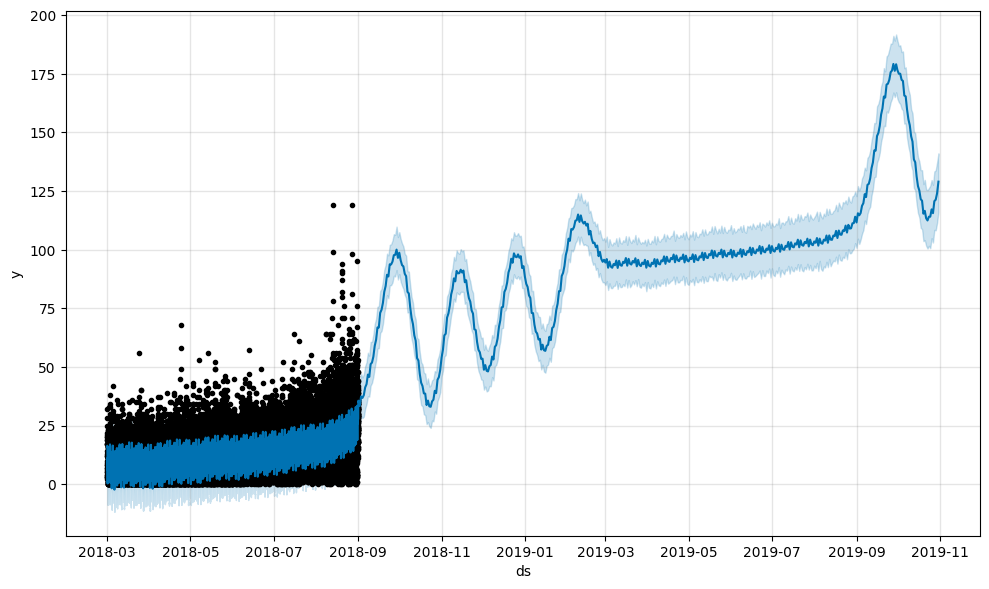

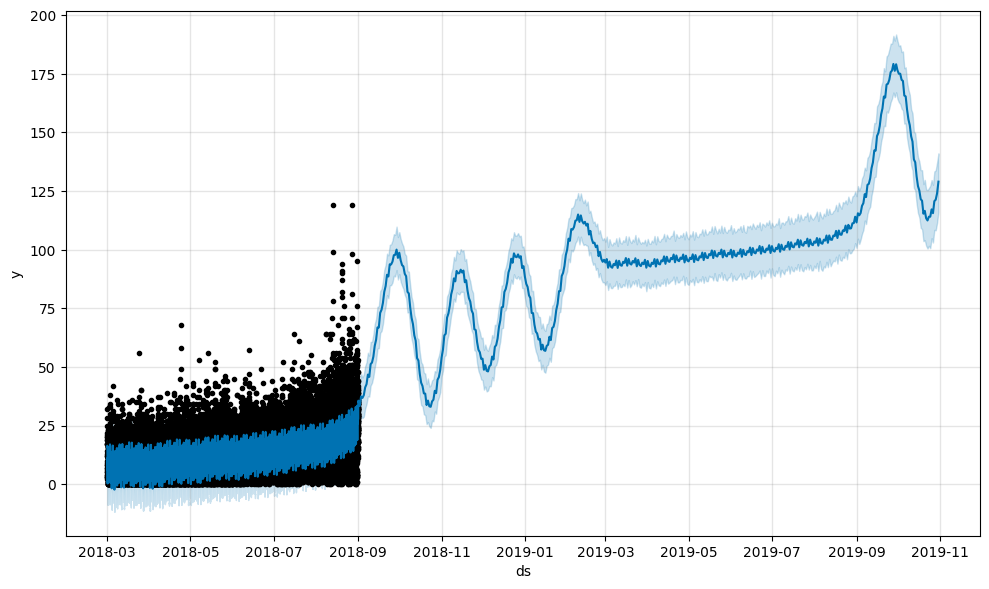

In [35]:
# Prophet Model Predictions Plot
fig = model.plot(forecast, uncertainty=True)
plt.title('Prophet Model Predictions')
plt.xlabel('Date')
plt.ylabel('Values')
plt.show()

model.plot(forecast, uncertainty=True)

### ARIMA

In [36]:
# ARIMA

# searching for the best params using auto_arima
model = auto_arima(
	target_train,
	exogenous=features_train,
	trace=True,
	error_action="ignore",
	suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=10.93 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=38346.200, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=37987.003, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=37835.761, Time=0.84 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=38344.202, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.47 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.82 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=6.30 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=37833.762, Time=0.37 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.89 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.91 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=37985.005, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=1.44 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 27.590 seconds


In [37]:
# getting predictions
forecast = model.predict(n_periods=len(target_test),  exogenous=features_test)

# RMSE
rmse_ar = np.sqrt(mean_squared_error(target_test, forecast))
print("RMSE:", rmse_ar)

RMSE: 90.80441911836029


### Results

In [38]:
# making a pivot table
results = pd.DataFrame({'RMSE': [rmse_lr, rmse_lgbm, rmse_xgb, rmse_lstm, rmse_pr, rmse_ar]},
                          index = ['LinearRegression', 'LGBM', 'XGBoost', 'LSTM', 'Prophet', 'ARIMA'])
results.sort_values(by='RMSE')
results

,RMSE
LinearRegression,24.065186
LGBM,24.489536
XGBoost,24.437094
LSTM,46.628559
Prophet,75.474244
ARIMA,90.804419


In [39]:
# the evaluation of forecast quality using the previous values of the time series

pred_previous = test['num_orders'].shift(fill_value=train.iloc[-1,0])
print("RMSE:", np.sqrt(mean_squared_error(test['num_orders'], pred_previous)))

RMSE: 58.819724582830204


The best RMSE is achieved by the Linear Regression model, and the result is better than when using the previous value of the series for forecasting evaluation. Let's apply the Linear Regression model to the test dataset.

## Testing

In [40]:
# let's apply the best model to the testing sample

predictions_test = best_model_lr.predict(features_test)
print('RMSE:', np.sqrt(mean_squared_error(target_test, predictions_test)))

RMSE: 34.933728921027395


The RMSE value on the test dataset is not greater than 48, which meets the requirements of the task.

In [41]:
# comparing the Result with the Dummy Model

# training the Dummy Model
dummy = DummyRegressor(strategy="median")
dummy.fit(features_train, target_train)

# predicting the values
dummy_pred = dummy.predict(features_test)

# calculating the final RMSE
print('RMSE:', np.sqrt(mean_squared_error(target_test, dummy_pred)))

RMSE: 87.03915278566916


The result of the final model is significantly better than that of the dummy model, indicating that the model is reasonable and performs well.

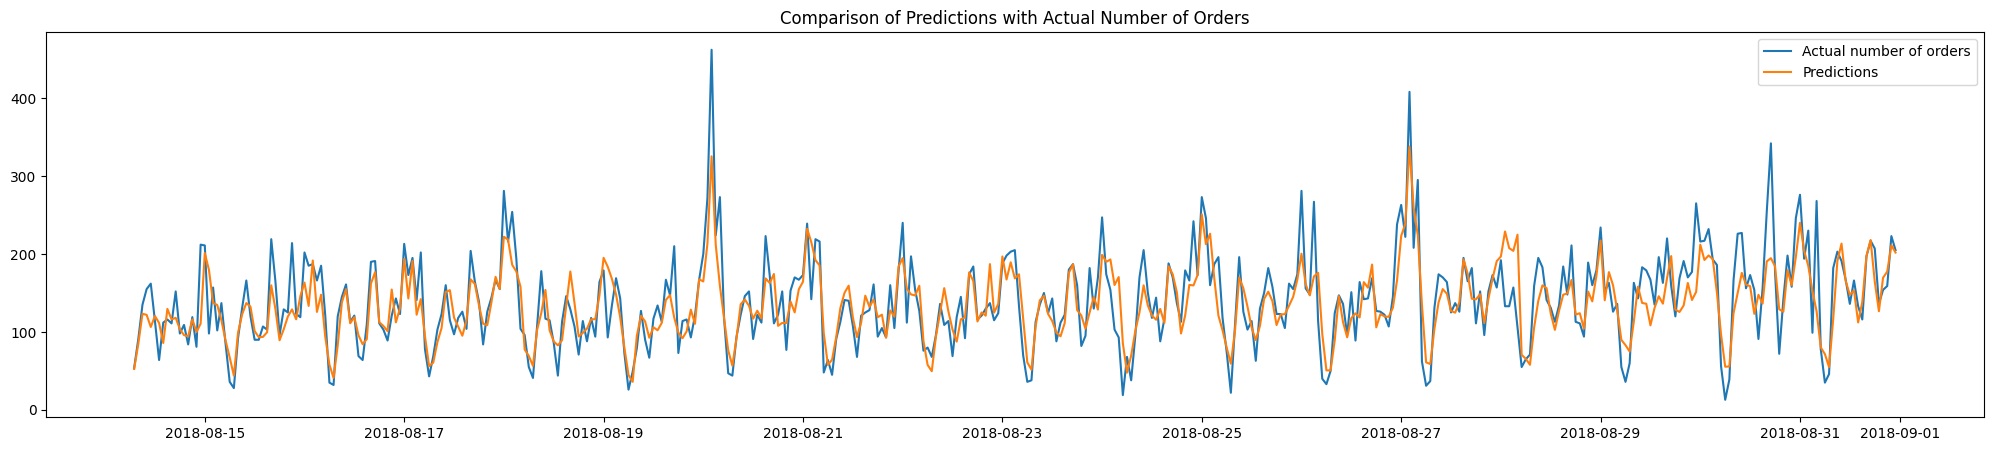

In [42]:
# predictions plot

plt.figure(figsize=(25, 5))
plt.plot(target_test.index, target_test, label='Actual number of orders')
plt.plot(target_test.index, predictions_test, label='Predictions')
plt.title('Comparison of Predictions with Actual Number of Orders')
plt.legend()
plt.show()

The predictions provide a more "averaged" result, but overall, they accurately reflect the fluctuations of the actual values. It can be observed that the accuracy decreases in the last week of August, which was anticipated from the residuals plot in the "Analysis" section.

## Summary

For forecasting the number of taxi orders at airports, data for the period from March to September 2018 was analyzed.

During the analysis, the following patterns were identified: there is a clear increase in the number of orders throughout the period, the highest number of orders is on Mondays and Fridays, the lowest number is on Tuesdays and Sundays, the peak order times are midnight and around 5 PM, and the lowest number of orders is at 6 AM. Lag features for 1 hour, 1 day, 1 week, and rolling averages for 1 week and 1 day were added as features for further use in ML models.

To predict the demand, Linear Regression, LGBMRegressor, XGBoost, LSTM, Prophet, and ARIMA models were trained. The RMSE metric was used to evaluate the prediction quality, and according to the task requirements, its value should not exceed 48 on the test set. The best result on the training set was achieved with the Linear Regression model (RMSE=24.06), and its performance on the test set is 34.9.